# TD 9-10 : Interface comparative et analyse temporelle

Ce notebook propose une interface simple pour comparer deux sous-corpus (Reddit vs Arxiv) et visualiser l'évolution temporelle de mots. Il réutilise les données déjà collectées dans `corpus.csv`.


In [ ]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt

from ipywidgets import VBox, HBox, Label, Text, Dropdown, IntSlider, Button, Output
from IPython.display import display, clear_output

from IPython.display import clear_output

# petit nettoyage  (mêmes règles que le reste du projet)
def nettoyer_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokens(text):
    return re.findall(r"\b\w+\b", nettoyer_text(text))


In [ ]:
# on charge le csv mixte (reddit + arxiv)
df = pd.read_csv("corpus.csv", sep=",")

# on remet des noms de colonnes uniformes
col_map = {
    "Titre": "titre",
    "Auteur": "auteur",
    "Date": "date",
    "URL": "url",
    "text": "texte"
}
df = df.rename(columns={k: v for k, v in col_map.items() if k in df.columns})

# sources en minuscule pour éviter les surprises
if "source" in df.columns:
    df["source"] = df["source"].str.lower()
else:
    df["source"] = "inconnue"

# parse des dates (on garde les erreurs en NaN)
df["date_parsed"] = pd.to_datetime(df["date"], errors="coerce")

print("Aperçu:")
print(df[["titre", "auteur", "source", "date"]].head())
print("\nSources disponibles:", df["source"].value_counts().to_dict())


Aperçu:
                                               titre  \
0  My favorite climate change fact that will blow...   
1   Climate change will create Dead zones in America   
2  Why are people on the climate subreddits so do...   
3                   I'm worried about climate change   
4  Invasive species, extreme fire risk, and toxin...   

                                              auteur  source        date  
0                                           solvanic  reddit  2022-09-29  
1                               ApplicationExtra4554  reddit  2025-11-16  
2                                          texphobia  reddit  2024-05-10  
3                               Dull_Entrepreneur468  reddit  2025-06-26  
4  Kimberley Miner, Laura Meyerson, . Climate Cha...   arxiv  2020-08-03  

Sources disponibles: {'arxiv': 10, 'reddit': 4}


In [5]:
def tf_par_source(df, source_value):
    """Retourne Counter des tokens pour une source donnée."""
    sous_df = df[df["source"] == source_value]
    compteur = Counter()
    for texte in sous_df["texte"].dropna():
        compteur.update(tokens(texte))
    return compteur


def comparer_tf(df, source1="reddit", source2="arxiv", top_n=20):
    """Construit un DataFrame comparant les TF des deux sources."""
    tf1 = tf_par_source(df, source1)
    tf2 = tf_par_source(df, source2)
    mots = set(tf1.keys()) | set(tf2.keys())
    data = []
    for mot in mots:
        c1 = tf1.get(mot, 0)
        c2 = tf2.get(mot, 0)
        if c1 + c2 == 0:
            continue
        data.append({
            "mot": mot,
            f"tf_{source1}": c1,
            f"tf_{source2}": c2,
            "diff": c1 - c2,
            "ratio": (c1 + 1) / (c2 + 1)  # lissage pour éviter division par zéro
        })
    res = pd.DataFrame(data)
    if res.empty:
        return res
    res = res.sort_values(by="diff", ascending=False)
    return res.head(top_n)


def evolution_mot(df, mots, freq="M"):
    """Retourne une série temporelle agrégée pour un ou plusieurs mots."""
    if isinstance(mots, str):
        mots = [mots]
    motif = r"|".join([re.escape(m) for m in mots])

    def contient(texte):
        if not isinstance(texte, str):
            return False
        return re.search(rf"\b({motif})\b", nettoyer_text(texte)) is not None

    tmp = df.dropna(subset=["date_parsed"]).copy()
    tmp["match"] = tmp["texte"].apply(contient)
    tmp = tmp[tmp["match"]]
    if tmp.empty:
        return pd.Series(dtype=int)
    serie = tmp.set_index("date_parsed").resample(freq)["match"].count()
    return serie


In [6]:
# Exemple rapide : comparaison Reddit vs Arxiv
res_tf = comparer_tf(df, "reddit", "arxiv", top_n=15)
res_tf


,mot,tf_reddit,tf_arxiv,diff,ratio
657,i,8,0,8,9.000000
875,there,4,0,4,5.000000
346,was,4,0,4,5.000000
10,this,9,6,3,1.428571
834,will,5,2,3,2.000000
268,news,3,0,3,4.000000
717,because,4,1,3,2.500000
718,why,2,0,2,3.000000
677,but,3,1,2,2.000000
380,bad,2,0,2,3.000000


C:\Users\DELL\AppData\Local\Temp\ipykernel_27136\2801706980.py:51: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  serie = tmp.set_index("date_parsed").resample(freq)["match"].count()


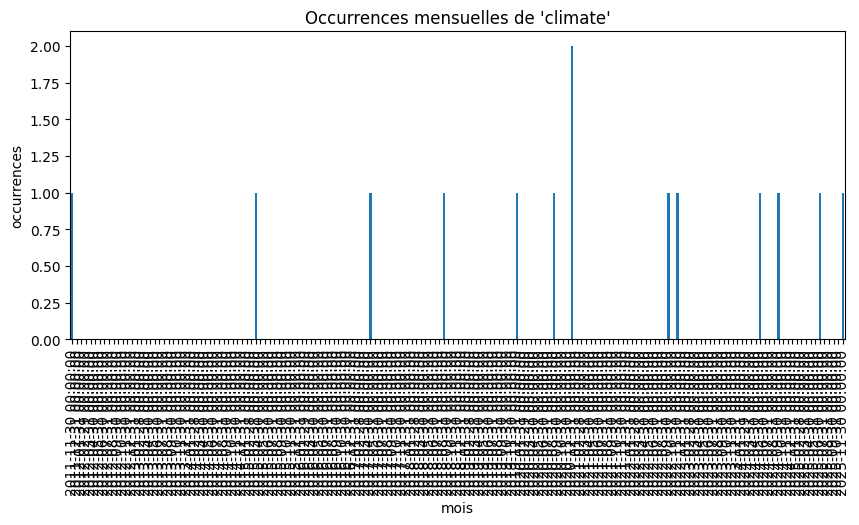

In [7]:
# Exemple rapide : évolution temporelle d'un mot
serie = evolution_mot(df, "climate", freq="M")
ax = serie.plot(kind="bar", figsize=(10,4), title="Occurrences mensuelles de 'climate'")
ax.set_xlabel("mois")
ax.set_ylabel("occurrences")
plt.show()


In [8]:
# Interface interactive (comparaison + timeline)

sources = sorted(df["source"].unique())
if "reddit" in sources and "arxiv" in sources:
    default_s1, default_s2 = "reddit", "arxiv"
else:
    default_s1, default_s2 = sources[0], sources[-1]

input_mots = Text(value="climate", description="Mots:")
select_s1 = Dropdown(options=sources, value=default_s1, description="Source 1")
select_s2 = Dropdown(options=sources, value=default_s2, description="Source 2")
slider_top = IntSlider(value=10, min=5, max=50, step=5, description="Top")
select_freq = Dropdown(options=[("Mensuel","M"),("Trimestriel","Q"),("Annuel","Y")], value="M", description="Fréq")
bouton = Button(description="Analyser", button_style="info", icon="search")
output = Output()


def on_click(b):
    with output:
        clear_output(wait=True)
        mots = input_mots.value.strip()
        if not mots:
            print("Merci de saisir au moins un mot.")
            return
        mots_list = [m.strip() for m in mots.split() if m.strip()]
        s1, s2 = select_s1.value, select_s2.value
        top_n = slider_top.value
        freq = select_freq.value

        print(f"Comparaison TF ({s1} vs {s2}) sur top {top_n}")
        res = comparer_tf(df, s1, s2, top_n=top_n)
        if res.empty:
            print("Aucune donnée pour ces sources.")
        else:
            display(res)

        print("\nÉvolution temporelle :")
        serie = evolution_mot(df, mots_list, freq=freq)
        if serie.empty:
            print("Aucune occurrence trouvée sur la période.")
        else:
            ax = serie.plot(kind="bar", figsize=(10,4), title=f"Occurrences de {mots_list} ({freq})")
            ax.set_xlabel("période")
            ax.set_ylabel("occurrences")
            plt.show()

bouton.on_click(on_click)

ui = VBox([
    Label(value="Analyse comparative (TF) + évolution temporelle"),
    HBox([input_mots, slider_top]),
    HBox([select_s1, select_s2, select_freq]),
    bouton,
    output
])

display(ui)
